# How might you think about this today, Chase?

In [1]:
%load_ext autoreload
%autoreload 2

from cadet_imports import *

In [2]:
import my_cadet_utils as cad_utils
import parameter_correlations as corr
import exploration_helper as explor

import multiprocessing as mp
import gc

In [3]:
results_folder = Path().absolute() / 'sim_results_updated_PREP_2021_transport_effect'
if not os.path.exists( results_folder.as_posix() ):
    os.makedirs( results_folder.as_posix() )

## Set up fixed parameters

Keq range and correlated Ds

In [4]:
resin  = 'phq'
keq_fit_params, Ds_fit_params = corr.get_correlation(resin)
Ds_fit_params = np.array(Ds_fit_params)

Ds_fit_params

/home/chase/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([[ 7.54087735e-12, -1.01787058e+00],
       [ 1.10039498e-11, -1.89305438e+00],
       [ 4.73345747e-12, -1.70831914e+00],
       [ 7.71250986e-12, -4.35260843e+00]])

In [5]:
a = np.mean(np.array([Ds_fit_params[i, 0] for i in range(3)]))
b = np.mean(np.array([Ds_fit_params[i, 1] for i in range(3)]))
print(a, b)

7.759428219587115e-12 -1.539748035729174


/home/chase/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


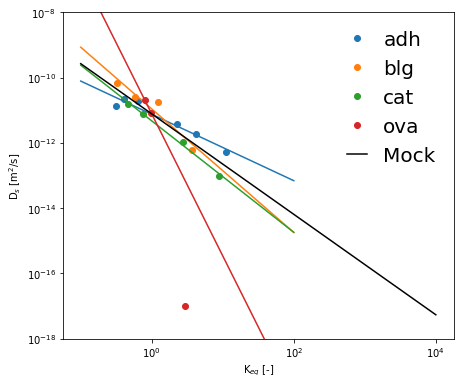

In [6]:
keq_vals = np.logspace(-1, 4, 3)
ds_vals  = np.array([explor.get_ds(keq, a, b) for keq in keq_vals])

fig, ax = plt.subplots()
corr.plot_ds(resin, fig, ax)

ax.plot(keq_vals, ds_vals, color='black', label='Mock')
ax.legend(loc='best', frameon=False, handlelength=1.0)


## What I'm changing

Mass and q_max

In [7]:
mass       = 50
cap_mg     = 100 # [mg/ml column]
q_m_fac    = cap_mg/(1.0-0.694)
q_max      = q_m_fac/mass # [mol m-3 resin]

q_max

6.535947712418299

Keq, c_load, and Dp

In [8]:
mg_per_ml_load = np.logspace(-3, 1, 5) 
c_load_vals    = mg_per_ml_load/mass # [mol m-3]

keq_vals = np.logspace(0, 4, 75)
dp = 1.0e-11

c_load_vals

array([2.e-05, 2.e-04, 2.e-03, 2.e-02, 2.e-01])

In [4]:
np.logspace(-3, 1, 5) 

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [9]:
t_max_vals = [1e6, 1e6, 2e5, 5e4, 5e3]

## Run simulations

In [14]:
args_list = []

for keq in keq_vals:
    for c_load, t_max in zip(c_load_vals, t_max_vals):
        ds = explor.get_ds(keq, a, b)
        args_list.append((c_load, dp, ds, q_max, keq, t_max, False))

In [15]:
def set_and_run(args):
    (c_load, dp, ds, q_max, keq, t_max, flag) = args
    ka = explor.get_ka(keq, q_max)
    sim = cad_utils.get_column_system_1_comp(load_c=c_load, 
                                                     Dp=dp, 
                                                     Ds=ds, 
                                                     q_max=q_max, 
                                                     ka=ka, 
                                                     t_max=t_max,
                                                     use_linear=False)

    run_time = time.time()
    file_name = f'c_{c_load:.1e}_Dp_{dp:.2e}_Keq_{keq:.2f}_fVolum_{1.633e-8:.2e}.h5'
    res_file = os.path.join(results_folder, file_name)
    cad_utils.run_simulation(sim, res_file)
    print(keq, f'{c_load:.1e}', time.time()-run_time, '\n')

In [16]:
pool      = mp.Pool(30)
results   = pool.map(set_and_run, args_list)
pool.close()
pool.join()

Simulation completed successfully
2.7066520700332415 2.0e-01 14.789865970611572 

Simulation completed successfully
1.0 2.0e-01 15.774052143096924 

Simulation completed successfully
1.6451905877536626 2.0e-01 15.907523393630981 

Simulation completed successfully
7.3259654282152304 2.0e-01 16.84385323524475 

Simulation completed successfully
4.452958509942655 2.0e-01 17.549700498580933 

Simulation completed successfully
12.052609368708426 2.0e-01 18.148412942886353 

Simulation completed successfully
1.1325413151528119 2.0e-02 31.866973638534546 

Simulation completed successfully
1.8632463119315603 2.0e-02 33.05255722999573 

Simulation completed successfully
8.29695852083491 2.0e-02 34.528313875198364 

Simulation completed successfully
3.0653952950565277 2.0e-02 36.0523784160614 

Simulation completed successfully
5.04315948717136 2.0e-02 37.66064405441284 

Simulation completed successfully
1.1325413151528119 2.0e-01 7.618794202804565 

Simulation completed successfully
13.65007


Simulation completed successfully
1.1325413151528119 2.0e-04 486.39952206611633 

Simulation completed successfully
8.29695852083491 2.0e-04 490.0259003639221 

Simulation completed successfully
1.8632463119315603 2.0e-04 492.7306146621704 

Simulation completed successfully
7.3259654282152304 2.0e-04 501.1318144798279 

Simulation completed successfully
3.0653952950565277 2.0e-04 484.2998459339142 

Simulation completed successfully
1.6451905877536626 2.0e-04 492.7569875717163 

Simulation completed successfully
9.396648314954696 2.0e-04 499.8812599182129 

Simulation completed successfully
Simulation completed successfully
3.4716868189265613 2.0e-04 484.60862851142883 

5.711586478126432 2.0e-04 491.5016314983368 

Simulation completed successfully
13.650078065460137 2.0e-04 490.0246424674988 

Simulation completed successfully
1.2826498305280605 2.0e-04 501.6420269012451 

Simulation completed successfully
12.052609368708426 2.0e-03 98.5483808517456 

Simulation completed successfu

270.66520700332416 2.0e-05 594.1791749000549 

Simulation completed successfully
22.45697995539774 2.0e-03 110.7570481300354 

Simulation completed successfully
32.622220097116696 2.0e-03 112.26003217697144 

Simulation completed successfully
19.828839491270713 2.0e-02 34.36241865158081 

Simulation completed successfully
128.26498305280612 2.0e-03 144.17548751831055 

Simulation completed successfully
77.96360130405237 2.0e-05 558.7117831707001 

Simulation completed successfully
306.539529505653 2.0e-05 560.0496904850006 

Simulation completed successfully
32.622220097116696 2.0e-02 38.29310154914856 

Simulation completed successfully
128.26498305280612 2.0e-05 529.3368558883667 

Simulation completed successfully
36.94601205199302 2.0e-03 122.55450963973999 

Simulation completed successfully
128.26498305280612 2.0e-02 52.74700427055359 

Simulation completed successfully
732.596542821523 2.0e-02 63.777812242507935 

Simulation completed successfully
53.66976945540476 2.0e-03 124.6

2245.6979955397765 2.0e-05 1023.0130949020386 

Simulation completed successfully
2880.4441533962977 2.0e-05 1052.9424352645874 

Simulation completed successfully
1545.9277364194786 2.0e-02 62.306591749191284 

Simulation completed successfully
646.8607661546328 2.0e-04 848.7589328289032 

Simulation completed successfully
10000.0 2.0e-03 400.4582233428955 

Simulation completed successfully
1545.9277364194786 2.0e-05 915.5052156448364 

Simulation completed successfully
7796.360130405237 2.0e-01 502.02843475341797 

Simulation completed successfully
732.596542821523 2.0e-04 840.564973115921 

Simulation completed successfully
6078.3231282972365 2.0e-01 442.16599106788635 

Simulation completed successfully
1064.2092440647245 2.0e-04 927.329380273819 

Simulation completed successfully
1545.9277364194786 2.0e-01 220.7198829650879 

Simulation completed successfully
10000.0 2.0e-02 206.01836824417114 

Simulation completed successfully
646.8607661546328 2.0e-03 245.61252975463867 

Sim

## Transport effect

In [28]:
args_list = []

t_max = 1e6
c_load = 2.0e-05

dp_vals = [6.0e-12, 2.0e-11]
fVolum_vals = [1.633e-8, 1.633e-8/4]

for keq in keq_vals:
    for dp in dp_vals:
        for fVolum in fVolum_vals:
            ds = explor.get_ds(keq, a, b)
            if keq > keq_vals[-10]:
                t_max = 5e6
            else:
                t_max = 1e6
            args_list.append((c_load, dp, ds, q_max, keq, t_max, False, fVolum))

In [29]:
def set_and_run(args):
    (c_load, dp, ds, q_max, keq, t_max, flag, fVolumetric) = args
    ka = explor.get_ka(keq, q_max)
    sim = cad_utils.get_column_system_1_comp(load_c=c_load, 
                                            Dp=dp, 
                                            Ds=ds, 
                                            q_max=q_max, 
                                            ka=ka, 
                                            t_max=t_max,
                                            use_linear=False,
                                            fVolumetric=fVolumetric)

    run_time = time.time()
    file_name = f'c_{c_load:.1e}_Dp_{dp:.2e}_fVolum_{fVolumetric:.2e}_Keq_{keq:.2f}.h5'
    res_file = os.path.join(results_folder, file_name)
    cad_utils.run_simulation(sim, res_file)
    print(file_name, time.time()-run_time, '\n')

In [ ]:
pool      = mp.Pool(30)
results   = pool.map(set_and_run, args_list)
pool.close()
pool.join()

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_1.63e-08_Keq_1.45.h5 444.13217401504517 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_3.47.h5 447.7188186645508 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_4.08e-09_Keq_4.45.h5 450.6681592464447 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_7.33.h5 454.0395107269287 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_4.08e-09_Keq_1.45.h5 455.2520935535431 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_4.08e-09_Keq_6.47.h5 457.02601075172424 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_1.13.h5 457.40186738967896 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_4.08e-09_Keq_1.00.h5 458.6717834472656 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_2.39.h5 459.1220989227295 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolu


Simulation completed successfully
Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_2.11.h5 507.9728946685791 

c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_6.47.h5 488.9419300556183 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_4.45.h5 482.99481773376465 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_3.07.h5 511.1737484931946 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_9.40.h5 493.59975576400757 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_4.08e-09_Keq_7.33.h5 493.07176756858826 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_1.63e-08_Keq_8.30.h5 508.1225554943085 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_4.08e-09_Keq_8.30.h5 525.2930870056152 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_1.63e-08_Keq_5.71.h5 476.3752691745758 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVol


Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_19.83.h5 507.1558473110199 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_4.08e-09_Keq_32.62.h5 524.8510551452637 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_41.84.h5 502.5373055934906 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_4.08e-09_Keq_53.67.h5 494.5315113067627 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_4.08e-09_Keq_47.39.h5 500.764240026474 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_60.78.h5 498.31243801116943 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_1.63e-08_Keq_36.95.h5 516.4122266769409 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_1.63e-08_Keq_53.67.h5 526.3712940216064 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_4.08e-09_Keq_77.96.h5 505.0466706752777 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-1

c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_393.18.h5 563.1278011798859 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_4.08e-09_Keq_1750.83.h5 926.0003855228424 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_1.63e-08_Keq_1982.88.h5 799.1184191703796 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_4.08e-09_Keq_445.30.h5 637.9773743152618 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_2245.70.h5 714.9727916717529 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_1.63e-08_Keq_732.60.h5 633.5488872528076 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_4.08e-09_Keq_504.32.h5 633.1856360435486 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_1.63e-08_Keq_571.16.h5 595.8079445362091 

Simulation completed successfully
c_2.0e-05_Dp_2.00e-11_fVolum_4.08e-09_Keq_2880.44.h5 993.8660318851471 

Simulation completed successfully
c_2.0e-05_Dp_6.00e-12_fVolum_4.08e-09_Keq_

### How does the t vs Keq slope change with flow rate and Dp?

In [10]:
results_folder = Path().absolute() / 'sim_results_t_vs_Keq_slope_mapping'
if not os.path.exists( results_folder.as_posix() ):
    os.makedirs( results_folder.as_posix() )
    
image_folder = Path().absolute() / 'images_t_vs_Keq_slope_mapping'
if not os.path.exists( image_folder.as_posix() ):
    os.makedirs( image_folder.as_posix() )

In [11]:
V_col = np.pi/4 * (0.5**2) * 1e-4 * 0.042 # [m3]
eps_t = 0.694

mass       = 50
cap_mg     = 100 # [mg/ml column]
q_m_fac    = cap_mg/(1.0-eps_t)
q_max      = q_m_fac/mass # [mol m-3 resin]

c_load = 2.0e-5

keq_vals = [1.0, 1000.0]
fVolum_vals = np.linspace(1.633e-8/10, 1.633e-8, 20)
dp_vals = np.linspace(5e-12, 1e-11, 10)

In [63]:
for fVolum in fVolum_vals:
    for dp in dp_vals:
        for keq in keq_vals:
            ds    = explor.get_ds(keq, a, b)
            t_max = 4.0*V_col/fVolum*(keq*(1-eps_t) + eps_t) + 5000
            ka    = explor.get_ka(keq, q_max)
            sim = cad_utils.get_column_system_1_comp_with_Q(load_c=c_load, 
                                                            Dp=dp, 
                                                            Ds=ds, 
                                                            q_max=q_max, 
                                                            ka=ka, 
                                                            t_max=t_max,
                                                            use_linear=False,
                                                            fVolumetric=fVolum)

            run_time = time.time()
            file_name = f'c_{c_load:.1e}_Q_{fVolum:.2e}_Dp_{dp:.2e}_Keq_{keq:.0e}.h5'
            res_file = os.path.join(results_folder, file_name)
            cad_utils.run_simulation(sim, res_file)
            print(file_name, time.time()-run_time, '\n')

Simulation completed successfully
c_2.0e-05_Q_1.63e-09_Dp_5.00e-12_Keq_1e+00.h5 2.6296849250793457 

Simulation completed successfully
c_2.0e-05_Q_1.63e-09_Dp_5.00e-12_Keq_1e+03.h5 332.37537455558777 

Simulation completed successfully
c_2.0e-05_Q_1.63e-09_Dp_5.56e-12_Keq_1e+00.h5 2.662811756134033 

Simulation completed successfully
c_2.0e-05_Q_1.63e-09_Dp_5.56e-12_Keq_1e+03.h5 336.9936089515686 

Simulation completed successfully
c_2.0e-05_Q_1.63e-09_Dp_6.11e-12_Keq_1e+00.h5 2.64105486869812 

Simulation completed successfully
c_2.0e-05_Q_1.63e-09_Dp_6.11e-12_Keq_1e+03.h5 325.61267924308777 

Simulation completed successfully
c_2.0e-05_Q_1.63e-09_Dp_6.67e-12_Keq_1e+00.h5 3.1585118770599365 

Simulation completed successfully
c_2.0e-05_Q_1.63e-09_Dp_6.67e-12_Keq_1e+03.h5 319.6434552669525 

Simulation completed successfully
c_2.0e-05_Q_1.63e-09_Dp_7.22e-12_Keq_1e+00.h5 2.666412830352783 

Simulation completed successfully
c_2.0e-05_Q_1.63e-09_Dp_7.22e-12_Keq_1e+03.h5 326.8345122337341

Simulation completed successfully
c_2.0e-05_Q_4.73e-09_Dp_5.56e-12_Keq_1e+00.h5 2.4049458503723145 

Simulation completed successfully
c_2.0e-05_Q_4.73e-09_Dp_5.56e-12_Keq_1e+03.h5 196.7439022064209 

Simulation completed successfully
c_2.0e-05_Q_4.73e-09_Dp_6.11e-12_Keq_1e+00.h5 2.0668022632598877 

Simulation completed successfully
c_2.0e-05_Q_4.73e-09_Dp_6.11e-12_Keq_1e+03.h5 126.6566059589386 

Simulation completed successfully
c_2.0e-05_Q_4.73e-09_Dp_6.67e-12_Keq_1e+00.h5 2.081479787826538 

Simulation completed successfully
c_2.0e-05_Q_4.73e-09_Dp_6.67e-12_Keq_1e+03.h5 139.88605165481567 

Simulation completed successfully
c_2.0e-05_Q_4.73e-09_Dp_7.22e-12_Keq_1e+00.h5 2.697676181793213 

Simulation completed successfully
c_2.0e-05_Q_4.73e-09_Dp_7.22e-12_Keq_1e+03.h5 124.72182726860046 

Simulation completed successfully
c_2.0e-05_Q_4.73e-09_Dp_7.78e-12_Keq_1e+00.h5 2.021176815032959 

Simulation completed successfully
c_2.0e-05_Q_4.73e-09_Dp_7.78e-12_Keq_1e+03.h5 131.584315776824

Simulation completed successfully
c_2.0e-05_Q_7.82e-09_Dp_6.11e-12_Keq_1e+00.h5 1.9229514598846436 

Simulation completed successfully
c_2.0e-05_Q_7.82e-09_Dp_6.11e-12_Keq_1e+03.h5 77.4555504322052 

Simulation completed successfully
c_2.0e-05_Q_7.82e-09_Dp_6.67e-12_Keq_1e+00.h5 2.2316434383392334 

Simulation completed successfully
c_2.0e-05_Q_7.82e-09_Dp_6.67e-12_Keq_1e+03.h5 85.41326713562012 

Simulation completed successfully
c_2.0e-05_Q_7.82e-09_Dp_7.22e-12_Keq_1e+00.h5 1.9164690971374512 

Simulation completed successfully
c_2.0e-05_Q_7.82e-09_Dp_7.22e-12_Keq_1e+03.h5 79.88390374183655 

Simulation completed successfully
c_2.0e-05_Q_7.82e-09_Dp_7.78e-12_Keq_1e+00.h5 1.9652042388916016 

Simulation completed successfully
c_2.0e-05_Q_7.82e-09_Dp_7.78e-12_Keq_1e+03.h5 138.66354846954346 

Simulation completed successfully
c_2.0e-05_Q_7.82e-09_Dp_8.33e-12_Keq_1e+00.h5 1.9166767597198486 

Simulation completed successfully
c_2.0e-05_Q_7.82e-09_Dp_8.33e-12_Keq_1e+03.h5 85.921685695648

Simulation completed successfully
c_2.0e-05_Q_1.09e-08_Dp_6.67e-12_Keq_1e+00.h5 2.191572666168213 

Simulation completed successfully
c_2.0e-05_Q_1.09e-08_Dp_6.67e-12_Keq_1e+03.h5 59.56772756576538 

Simulation completed successfully
c_2.0e-05_Q_1.09e-08_Dp_7.22e-12_Keq_1e+00.h5 2.0173025131225586 

Simulation completed successfully
c_2.0e-05_Q_1.09e-08_Dp_7.22e-12_Keq_1e+03.h5 97.1685471534729 

Simulation completed successfully
c_2.0e-05_Q_1.09e-08_Dp_7.78e-12_Keq_1e+00.h5 1.8773021697998047 

Simulation completed successfully
c_2.0e-05_Q_1.09e-08_Dp_7.78e-12_Keq_1e+03.h5 97.91145396232605 

Simulation completed successfully
c_2.0e-05_Q_1.09e-08_Dp_8.33e-12_Keq_1e+00.h5 1.8955514430999756 

Simulation completed successfully
c_2.0e-05_Q_1.09e-08_Dp_8.33e-12_Keq_1e+03.h5 67.6026759147644 

Simulation completed successfully
c_2.0e-05_Q_1.09e-08_Dp_8.89e-12_Keq_1e+00.h5 1.8395299911499023 

Simulation completed successfully
c_2.0e-05_Q_1.09e-08_Dp_8.89e-12_Keq_1e+03.h5 68.66739296913147 

Simulation completed successfully
c_2.0e-05_Q_1.40e-08_Dp_7.22e-12_Keq_1e+00.h5 1.9459240436553955 

Simulation completed successfully
c_2.0e-05_Q_1.40e-08_Dp_7.22e-12_Keq_1e+03.h5 78.80020689964294 

Simulation completed successfully
c_2.0e-05_Q_1.40e-08_Dp_7.78e-12_Keq_1e+00.h5 1.8379597663879395 

Simulation completed successfully
c_2.0e-05_Q_1.40e-08_Dp_7.78e-12_Keq_1e+03.h5 50.01602029800415 

Simulation completed successfully
c_2.0e-05_Q_1.40e-08_Dp_8.33e-12_Keq_1e+00.h5 1.8381216526031494 

Simulation completed successfully
c_2.0e-05_Q_1.40e-08_Dp_8.33e-12_Keq_1e+03.h5 54.28686308860779 

Simulation completed successfully
c_2.0e-05_Q_1.40e-08_Dp_8.89e-12_Keq_1e+00.h5 1.8534178733825684 

Simulation completed successfully
c_2.0e-05_Q_1.40e-08_Dp_8.89e-12_Keq_1e+03.h5 88.26391410827637 

Simulation completed successfully
c_2.0e-05_Q_1.40e-08_Dp_9.44e-12_Keq_1e+00.h5 2.3827388286590576 

Simulation completed successfully
c_2.0e-05_Q_1.40e-08_Dp_9.44e-12_Keq_1e+03.h5 53.908614635467

In [15]:
for keq in keq_vals:
    ds = explor.get_ds(keq, a, b)
    print(ds)
print('\n', dp_vals)

7.759428219587115e-12
1.8645997117750956e-16

 [5.00000000e-12 5.55555556e-12 6.11111111e-12 6.66666667e-12
 7.22222222e-12 7.77777778e-12 8.33333333e-12 8.88888889e-12
 9.44444444e-12 1.00000000e-11]
